# **Ensemble Learning**


Defining root folder for root resources access such as `data/` and `utils/`


In [2]:
from pathlib import Path
import sys

ROOT_DIR = Path.cwd().parent
sys.path.insert(0, str(ROOT_DIR))

## **Importing libraries**


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path
from torch import nn
from utils import helpers
import os
from PIL import Image

/home/shiba/Programming/nail-disease-classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data


In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader


# Normalization and transforming data into tensors
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

DATA_DIR = ROOT_DIR / "data"
TEST_DIR = DATA_DIR / "test"
test_data = ImageFolder(root=TEST_DIR,
                        transform=transform,
                        target_transform=None)

class_names = test_data.classes
num_classes = len(class_names)

# Test Dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Models


In [5]:
OUTPUTS_PATH = ROOT_DIR / "outputs"

### EfficientNetV2S


In [6]:
from torchvision import models

MODEL_NAME = "efficientnetv2s"
EPOCH = 5

# Rebuilding model
efficientnetv2s = models.efficientnet_v2_s()
efficientnetv2s.classifier[1] = nn.Linear(
    efficientnetv2s.classifier[1].in_features, num_classes)
efficientnetv2s = efficientnetv2s.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
efficientnetv2s.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### SwinV2B


In [7]:
MODEL_NAME = "swinv2b"
EPOCH = 5

# Rebuilding Model
swinv2b = models.swin_v2_b()
swinv2b.head = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
swinv2b.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
swinv2b.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### RegNetY16GF


In [8]:
MODEL_NAME = "regnety16gf"
EPOCH = 5

# Rebuilding Model
regnety16gf = models.regnet_y_16gf()
regnety16gf.fc = nn.Linear(
    in_features=3024, out_features=num_classes, bias=True)
regnety16gf.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
regnety16gf.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### Resnet50


In [9]:
MODEL_NAME = "resnet50"
EPOCH = 5

# Rebuilding Model
resnet50 = models.resnet50()
resnet50.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
resnet50.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
resnet50.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### VGG16


In [26]:
MODEL_NAME = "vgg16"
EPOCH = 5

# Rebuilding Model
vgg16 = models.vgg16()
# Change VGG16 to output 10 classes
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
vgg16 = vgg16.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
vgg16.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

## Ensemble Learning


In [27]:
model_list = [efficientnetv2s.eval(),
              swinv2b.eval(),
              regnety16gf.eval(),
              resnet50.eval(),
              vgg16.eval()]

model_accuracies = [0.88, 0.90, 0.85, 0.75, 0.72]

In [29]:
from tqdm import tqdm
import torch


def evaluate_ensemble(model_list, weights, dataloader, device):
    model_weights = torch.tensor(weights, dtype=torch.float32)
    model_weights /= model_weights.sum()

    all_preds = []
    all_labels = []

    for model in model_list:
        model.to(device)
        model.eval()

    with torch.inference_mode():
        for images, labels in tqdm(dataloader, desc="Evaluating Ensemble"):
            images = images.to(device)
            labels = labels.to(device)

            probs = []
            for model in model_list:
                outputs = model(images)
                prob = torch.softmax(outputs, dim=1)
                probs.append(prob)

            # (num_models, batch_size, num_classes)
            stacked_probs = torch.stack(probs)
            weighted_probs = torch.sum(
                stacked_probs * model_weights[:, None, None], dim=0)
            preds = torch.argmax(weighted_probs, dim=1)

            all_preds.append(preds)
            all_labels.append(labels)

    return torch.cat(all_preds), torch.cat(all_labels)

Evaluating Ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Ensemble: 100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


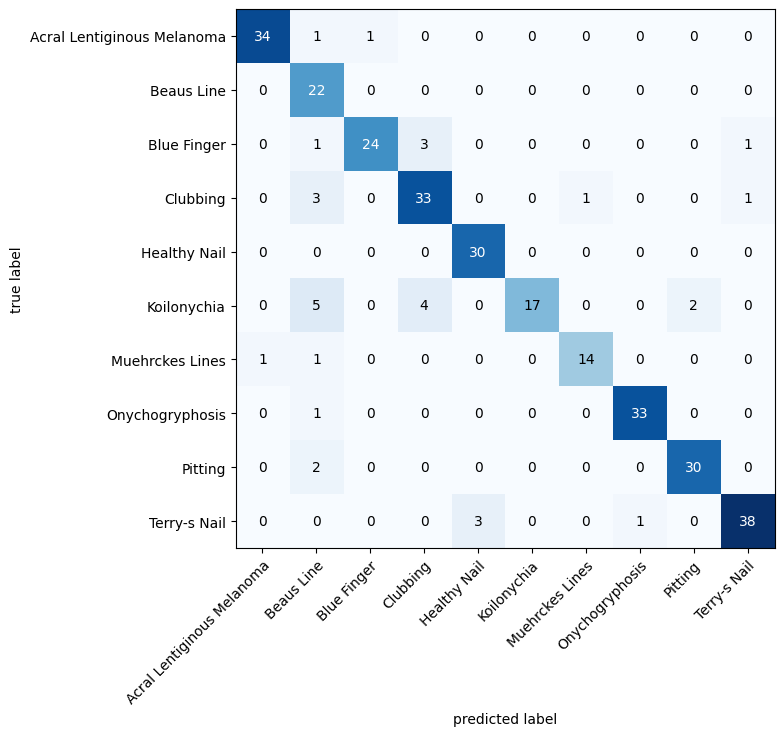

In [30]:
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds, y_true = evaluate_ensemble(
    model_list, model_accuracies, test_dataloader, device)


conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10, 7))

In [32]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=class_names)
print(report)

correct = sum(y_preds == y_true).item()
wrong = sum(y_preds != y_true).item()
total = len(y_true)

print(f"Correct Predictions: {correct}")
print(f"Wrong Predictions: {wrong}")
print(f"Total: {total}")

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.94      0.97      0.96        35
                Beaus Line       1.00      0.61      0.76        36
               Blue Finger       0.83      0.96      0.89        25
                  Clubbing       0.87      0.82      0.85        40
              Healthy Nail       1.00      0.91      0.95        33
               Koilonychia       0.61      1.00      0.76        17
           Muehrckes Lines       0.88      0.93      0.90        15
           Onychogryphosis       0.97      0.97      0.97        34
                   Pitting       0.94      0.94      0.94        32
              Terry-s Nail       0.90      0.95      0.93        40

                  accuracy                           0.90       307
                 macro avg       0.89      0.91      0.89       307
              weighted avg       0.91      0.90      0.90       307

Correct Predictions: 275
Wrong Predictions: 3